#Система оценки дефолта по кредитным картам

Целью данного проекта является разработка системы машинного обучения
для прогнозирования вероятности дефолта по кредитным картам
с последующим развертыванием модели через веб-интерфейс.

## Импорт библиотек

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
import gradio as gr
import joblib
import json

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style("whitegrid")

## Загрузка данных и первый взгляд

Датасет загружается напрямую из репозитория UCI Machine Learning для обеспечения воспроизводимости анализа.

Ссылка на источник датасета: https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"

# Чтение данных (пропустил первую строку с названиями на китайском)
df = pd.read_excel(url, header=1)

print(f"Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")
print("\nПЕРВЫЕ 5 СТРОК ДАННЫХ:")
print(df.head())
print("\nИНФОРМАЦИЯ О ДАННЫХ:")
print(df.info())

Размер датасета: 30000 строк, 25 столбцов

ПЕРВЫЕ 5 СТРОК ДАННЫХ:
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT

## Описание признаков

- **LIMIT_BAL**: Кредитный лимит (NT dollar)
- **SEX**: Пол (1=мужской, 2=женский)
- **EDUCATION**: Образование (1=аспирант, 2=университет, 3=школа, 4=другое)
- **MARRIAGE**: Семейное положение (1=женат/замужем, 2=холост/не замужем, 3=другое)
- **AGE**: Возраст (годы)
- **PAY_0**: Статус погашения в сентябре (-2=нет операций, -1=оплачено вовремя, 0=использована рассрочка, 1=задержка 1 мес, ...)
- **PAY_2**: Статус погашения в августе
- **PAY_3**: Статус погашения в июле
- **PAY_4**: Статус погашения в июне
- **PAY_5**: Статус погашения в мае
- **PAY_6**: Статус погашения в апреле
- **BILL_AMT1**: Сумма счета в сентябре (NT dollar)
- **BILL_AMT2**: Сумма счета в августе
- **BILL_AMT3**: Сумма счета в июле
- **BILL_AMT4**: Сумма счета в июне
- **BILL_AMT5**: Сумма счета в мае
- **BILL_AMT6**: Сумма счета в апреле
- **PAY_AMT1**: Сумма платежа в сентябре (NT dollar)
- **PAY_AMT2**: Сумма платежа в августе
- **PAY_AMT3**: Сумма платежа в июле
- **PAY_AMT4**: Сумма платежа в июне
- **PAY_AMT5**: Сумма платежа в мае
- **PAY_AMT6**: Сумма платежа в апреле
- **default**: Целевая переменная: Дефолт в следующем месяце (1=да, 0=нет)

## Предобработка данных

In [ ]:
df.rename(columns={'default payment next month': 'default'}, inplace=True)

# Столбец ID не информативный, удалим
df.drop('ID', axis=1, inplace=True)

print(f"Новый размер данных: {df.shape}")

Новый размер данных: (30000, 24)


Целевая переменная переименована в 'default'
Столбец 'ID' удален

Базовая статистика

In [ ]:
print(f"• Размер датасета: {df.shape[0]} клиентов, {df.shape[1]} признаков")
print(f"• Пропущенные значения: {df.isnull().sum().sum()}")
print(f"• Дубликаты: {df.duplicated().sum()}")
print(f"• Типы данных: {df.dtypes.nunique()} уникальных типа")

• Размер датасета: 30000 клиентов, 24 признаков
• Пропущенные значения: 0
• Дубликаты: 35
• Типы данных: 1 уникальных типа


Анализ целевой переменной

In [ ]:
default_counts = df['default'].value_counts()
print(f"• Без дефолта (0): {default_counts[0]} ({default_counts[0]/len(df)*100:.1f}%)")
print(f"• С дефолтом (1): {default_counts[1]} ({default_counts[1]/len(df)*100:.1f}%)")

• Без дефолта (0): 23364 (77.9%)
• С дефолтом (1): 6636 (22.1%)


Визуализация распределения целевой переменной

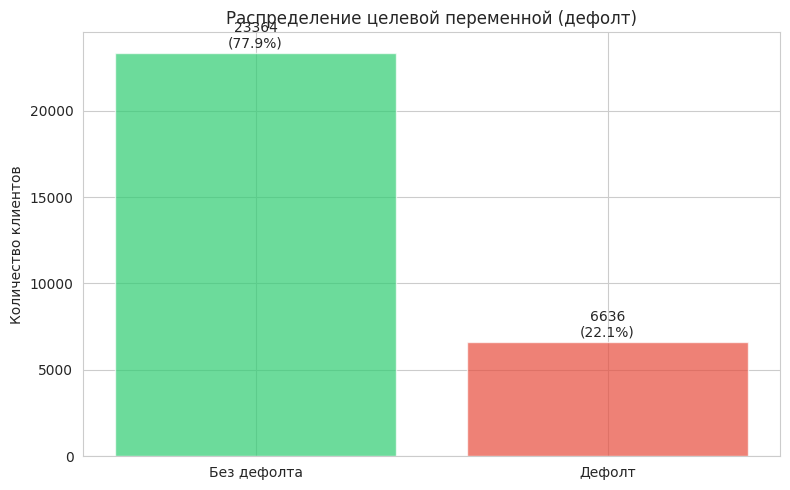


ВЫВОД: Имеем несбалансированный датасет с 22.1% дефолтов


In [ ]:
plt.figure(figsize=(8, 5))
colors = ['#2ecc71', '#e74c3c']
bars = plt.bar(['Без дефолта', 'Дефолт'], default_counts.values, color=colors, alpha=0.7)
plt.title('Распределение целевой переменной (дефолт)')
plt.ylabel('Количество клиентов')

for bar, count in zip(bars, default_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
             f'{count}\n({count/len(df)*100:.1f}%)', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\nВЫВОД: Имеем несбалансированный датасет с {default_counts[1]/len(df)*100:.1f}% дефолтов")

## Обработка дубликатов и анализ категориальных признаков

In [ ]:
print(f"Найдено дубликатов: {df.duplicated().sum()}")
df = df.drop_duplicates()
print(f"Данные после удаления дубликатов: {df.shape[0]} строк")

Найдено дубликатов: 35
Данные после удаления дубликатов: 29965 строк


Дубликаты удалены, теперь можем перейти к анализу категориальных признаков

РАСПРЕДЕЛЕНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ:


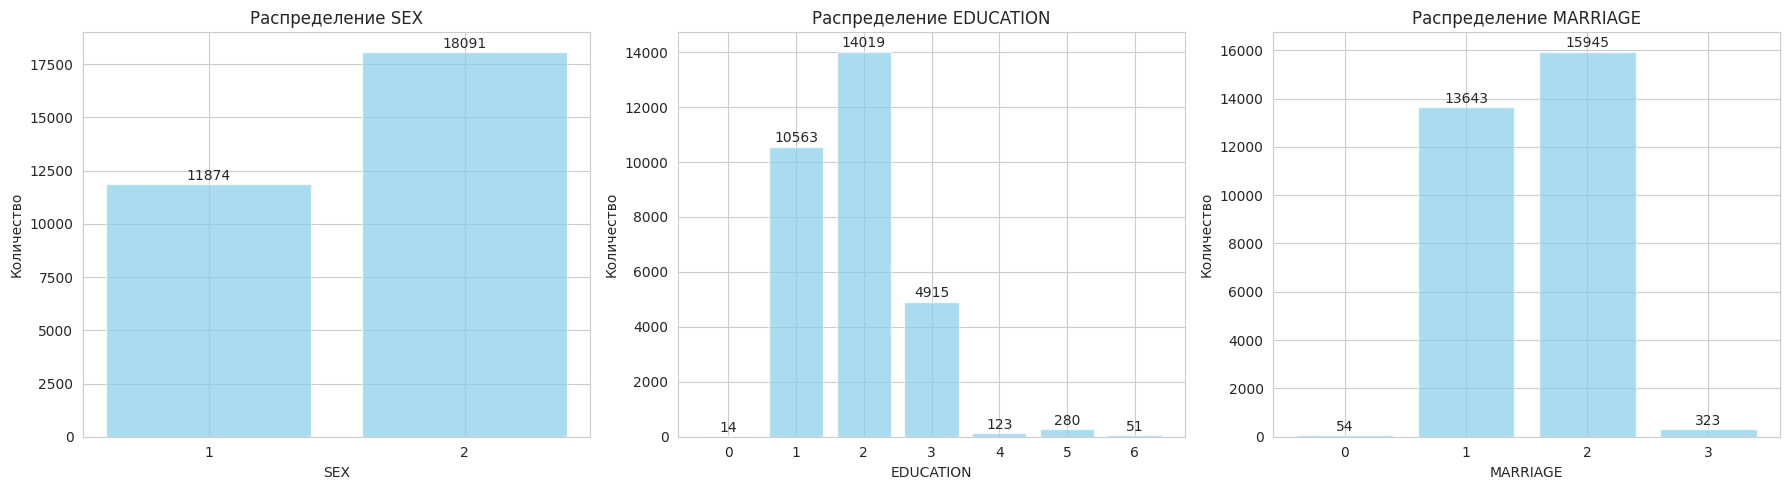


SEX:
  1: 11874 (39.6%)
  2: 18091 (60.4%)

EDUCATION:
  0: 14 (0.0%)
  1: 10563 (35.3%)
  2: 14019 (46.8%)
  3: 4915 (16.4%)
  4: 123 (0.4%)
  5: 280 (0.9%)
  6: 51 (0.2%)

MARRIAGE:
  0: 54 (0.2%)
  1: 13643 (45.5%)
  2: 15945 (53.2%)
  3: 323 (1.1%)


In [ ]:
categorical_features = ['SEX', 'EDUCATION', 'MARRIAGE']
print("РАСПРЕДЕЛЕНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ:")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, feature in enumerate(categorical_features):
    value_counts = df[feature].value_counts().sort_index()
    axes[i].bar(value_counts.index.astype(str), value_counts.values, alpha=0.7, color='skyblue')
    axes[i].set_title(f'Распределение {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Количество')

    for j, count in enumerate(value_counts.values):
        axes[i].text(j, count + 50, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

for feature in categorical_features:
    value_counts = df[feature].value_counts().sort_index()
    print(f"\n{feature}:")
    for value, count in value_counts.items():
        percentage = count / len(df) * 100
        print(f"  {value}: {count} ({percentage:.1f}%)")

**Пол (SEX):**
- Женщины: 18,091 (60.4%) - преобладают в выборке
- Мужчины: 11,874 (39.6%)

**Образование (EDUCATION):**
- Университет: 14,019 (46.8%) - наибольшая группа
- Аспирант: 10,563 (35.3%)
- Школа: 4,915 (16.4%)
- Другие/Неизвестно: 468 (1.6%) - требуется объединение категорий

**Семейное положение (MARRIAGE):**
- Холост/Не замужем: 15,945 (53.2%)
- Женат/Замужем: 13,643 (45.5%)
- Другое/Неизвестно: 377 (1.3%)


Анализ платёжной истории


Сентябрь (PAY_0):
  -2 - Нет операций        : 2,750 (  9.2%)
  -1 - Оплачено вовремя    : 5,682 ( 19.0%)
   0 - Использована рассрочка: 14,737 ( 49.2%)
   1 - Задержка 1 месяц    : 3,667 ( 12.2%)
   2 - Задержка 2 месяца   : 2,666 (  8.9%)
   3 - Задержка 3 месяца   :   322 (  1.1%)
   4 - Задержка 4 месяца   :    76 (  0.3%)
   5 - Задержка 5 месяцев  :    26 (  0.1%)
   6 - Задержка 6 месяцев  :    11 (  0.0%)
   7 - Задержка 7 месяцев  :     9 (  0.0%)
   8 - Задержка 8 месяцев  :    19 (  0.1%)

Август (PAY_2):
  -2 - Нет операций        : 3,752 ( 12.5%)
  -1 - Оплачено вовремя    : 6,046 ( 20.2%)
   0 - Использована рассрочка: 15,730 ( 52.5%)
   1 - Задержка 1 месяц    :    28 (  0.1%)
   2 - Задержка 2 месяца   : 3,926 ( 13.1%)
   3 - Задержка 3 месяца   :   326 (  1.1%)
   4 - Задержка 4 месяца   :    99 (  0.3%)
   5 - Задержка 5 месяцев  :    25 (  0.1%)
   6 - Задержка 6 месяцев  :    12 (  0.0%)
   7 - Задержка 7 месяцев  :    20 (  0.1%)
   8 - Задержка 8 месяцев  :     1

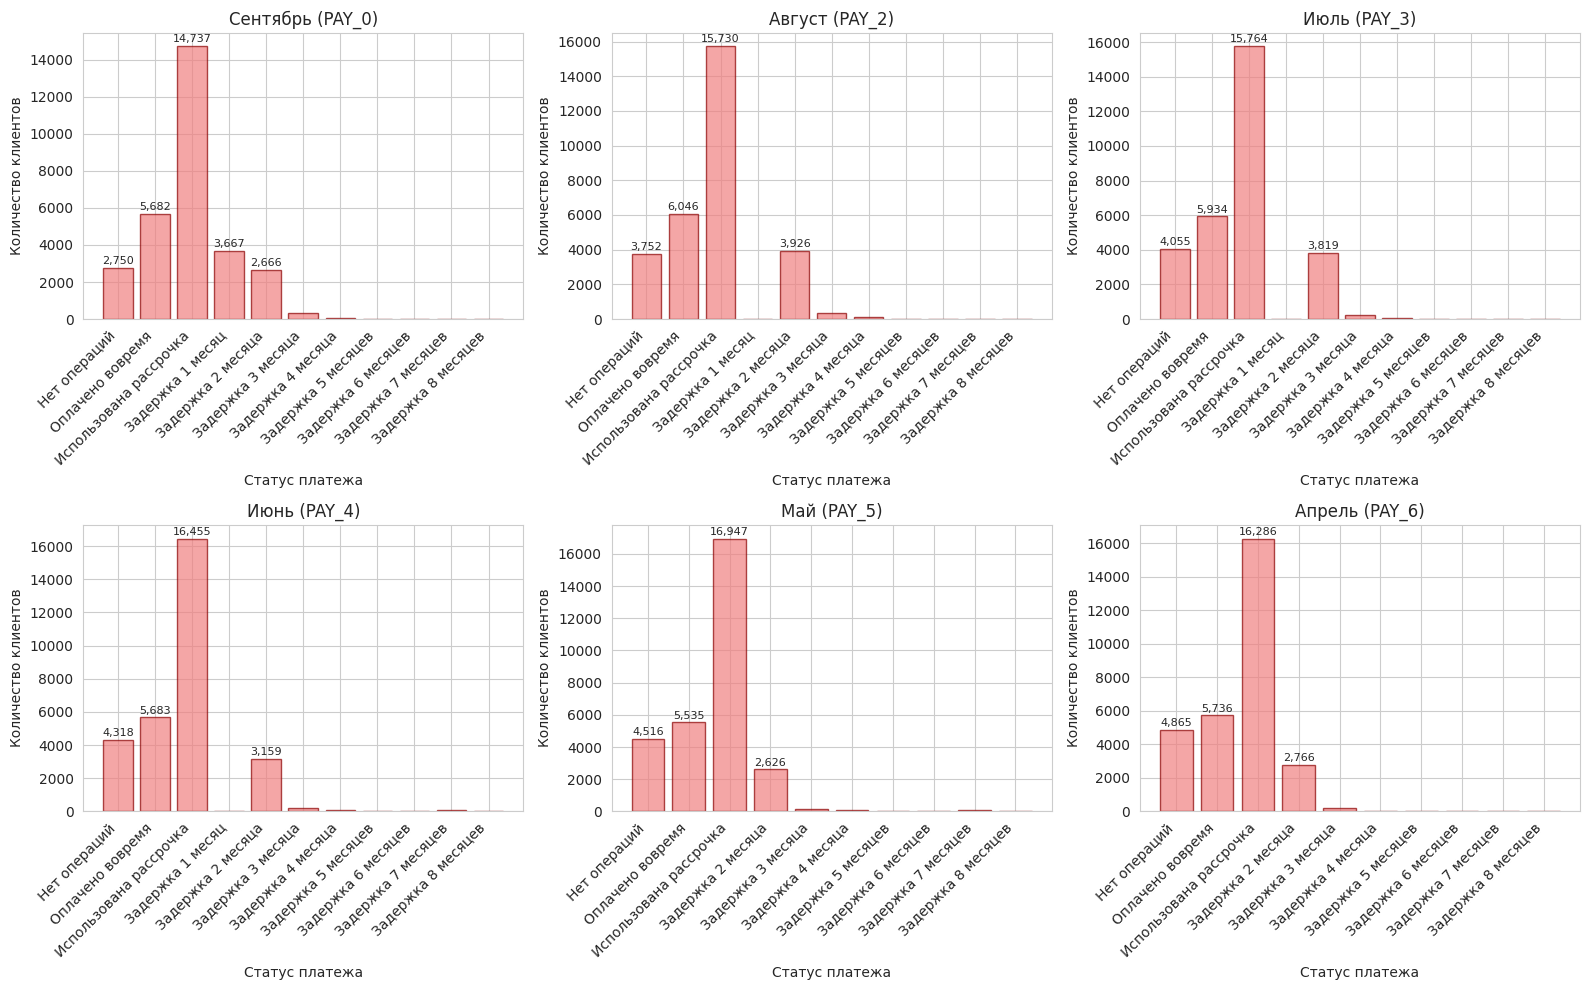

In [ ]:
payment_mapping = {
    -2: 'Нет операций',
    -1: 'Оплачено вовремя',
    0: 'Использована рассрочка',
    1: 'Задержка 1 месяц',
    2: 'Задержка 2 месяца',
    3: 'Задержка 3 месяца',
    4: 'Задержка 4 месяца',
    5: 'Задержка 5 месяцев',
    6: 'Задержка 6 месяцев',
    7: 'Задержка 7 месяцев',
    8: 'Задержка 8 месяцев'
}

pay_columns = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
month_names = ['Сентябрь', 'Август', 'Июль', 'Июнь', 'Май', 'Апрель']

for i, col in enumerate(pay_columns):
    print(f"\n{month_names[i]} ({col}):")
    value_counts = df[col].value_counts().sort_index()

    for value, count in value_counts.items():
        percentage = count / len(df) * 100
        status = payment_mapping.get(value, f'Задержка {value} месяцев')
        print(f"  {value:2} - {status:<20}: {count:5,} ({percentage:5.1f}%)")

plt.figure(figsize=(16, 10))
for i, col in enumerate(pay_columns, 1):
    plt.subplot(2, 3, i)
    value_counts = df[col].value_counts().sort_index()

    labels = [payment_mapping.get(val, str(val)) for val in value_counts.index]

    bars = plt.bar(range(len(value_counts)), value_counts.values,
                   alpha=0.7, color='lightcoral', edgecolor='darkred')
    plt.title(f'{month_names[i-1]} ({col})')
    plt.xlabel('Статус платежа')
    plt.ylabel('Количество клиентов')
    plt.xticks(range(len(labels)), labels, rotation=45, ha='right')

    for bar, count in zip(bars, value_counts.values):
        if count > 500:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
                    f'{count:,}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

**Что мы выяснили:**
- Распределения практически идентичны для всех 6 месяцев
- Доминирующие статусы платежей:
  - "0" (Использована рассрочка): ~14,000-15,000 клиентов ежемесячно
  - "-1" (Оплачено вовремя): ~10,000-12,000 клиентов
- Задержки платежей:
  - 1 месяц: ~3,000-4,000 клиентов
  - 2+ месяцев: значительно меньше клиентов

**Стабильность поведения:**
- Клиенты демонстрируют стабильные платежные привычки
- Месячные колебания минимальны
- PAY_0 (последний месяц) наиболее релевантен для прогнозирования

Бизнес-выводы:

1. **Целевая аудитория**: Преимущественно женщины с высшим образованием
2. **Платежные привычки**: Более 50% клиентов регулярно используют рассрочку, что указывает на постоянную финансовую нагрузку
3. **Ключевой риск**: Даже однократная задержка платежа на 1 месяц является сильным предиктором будущего дефолта
4. **Стабильность данных**: Поведенческие паттерны устойчивы во времени

Как можно улучшить модель:
- Сфокусироваться на анализе платежной истории, особенно последнего месяца (PAY_0)
- Объединить редкие категории образования для улучшения стабильности модели
- Создать производные признаки на основе истории платежей
- Использовать демографические данные как вспомогательные факторы

От слов к делу

### Анализ PAY_0 с статистикой дефолтов

In [ ]:
pay_0_analysis = df['PAY_0'].value_counts().sort_index()
payment_descriptions = {
    -2: 'Нет операций',
    -1: 'Оплачено вовремя',
    0: 'Рассрочка',
    1: 'Задержка 1 мес',
    2: 'Задержка 2 мес',
    3: 'Задержка 3 мес',
    4: 'Задержка 4 мес',
    5: 'Задержка 5 мес',
    6: 'Задержка 6 мес',
    7: 'Задержка 7 мес',
    8: 'Задержка 8 мес'
}

print("Статус платежа | Количество | Доля выборки | Дефолт %")
print("-" * 55)

for status, count in pay_0_analysis.items():
    status_desc = payment_descriptions.get(status, f'Задержка {status} мес')
    sample_percentage = (count / len(df)) * 100
    default_rate = df[df['PAY_0'] == status]['default'].mean() * 100

    print(f"{status:2} ({status_desc:15}) | {count:7,} | {sample_percentage:5.1f}% | {default_rate:5.1f}%")

Статус платежа | Количество | Доля выборки | Дефолт %
-------------------------------------------------------
-2 (Нет операций   ) |   2,750 |   9.2% |  13.2%
-1 (Оплачено вовремя) |   5,682 |  19.0% |  16.8%
 0 (Рассрочка      ) |  14,737 |  49.2% |  12.8%
 1 (Задержка 1 мес ) |   3,667 |  12.2% |  34.0%
 2 (Задержка 2 мес ) |   2,666 |   8.9% |  69.1%
 3 (Задержка 3 мес ) |     322 |   1.1% |  75.8%
 4 (Задержка 4 мес ) |      76 |   0.3% |  68.4%
 5 (Задержка 5 мес ) |      26 |   0.1% |  50.0%
 6 (Задержка 6 мес ) |      11 |   0.0% |  54.5%
 7 (Задержка 7 мес ) |       9 |   0.0% |  77.8%
 8 (Задержка 8 мес ) |      19 |   0.1% |  57.9%


НАм стоит сделать следующие платёжные признаки для оптимизации:
- recent_delay_flag - была ли задержка в PAY_0
- max_delay_6m - максимальная задержка за 6 месяцев
- total_delays_count - количество месяцев с задержками
- is_always_ontime - всегда ли платил вовремя (-1)
- payment_deterioration - ухудшается ли платежная дисциплина
- uses_installment_often - часто ли использует рассрочку

### Создание производных признаков

In [ ]:
df_enhanced = df.copy()

# 1. Флаг задержки в последнем месяце
df_enhanced['recent_delay_flag'] = (df_enhanced['PAY_0'] > 0).astype(int)

# 2. Максимальная задержка за 6 месяцев
pay_columns = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
df_enhanced['max_delay_6m'] = df_enhanced[pay_columns].max(axis=1)

# 3. Количество месяцев с задержками
df_enhanced['total_delays_count'] = (df_enhanced[pay_columns] > 0).sum(axis=1)

# 4. Всегда ли платил вовремя (все PAY_X = -1)
df_enhanced['is_always_ontime'] = (df_enhanced[pay_columns] == -1).all(axis=1).astype(int)

# 5. Часто ли использует рассрочку (более 3 месяцев с PAY_X = 0)
df_enhanced['uses_installment_often'] = ((df_enhanced[pay_columns] == 0).sum(axis=1) >= 3).astype(int)

# 6. Ухудшается ли платежная дисциплина (последний месяц хуже предыдущих)
def calculate_deterioration(row):
    recent = row['PAY_0']
    previous = row[['PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']].max()
    return 1 if recent > previous else 0

df_enhanced['payment_deterioration'] = df_enhanced.apply(calculate_deterioration, axis=1)

print("Создано 6 производных признаков:")
new_features = ['recent_delay_flag', 'max_delay_6m', 'total_delays_count',
                'is_always_ontime', 'uses_installment_often', 'payment_deterioration']

for feature in new_features:
    print(f"  • {feature}")

print("\nАНАЛИЗ СВЯЗИ НОВЫХ ПРИЗНАКОВ С ДЕФОЛТОМ:")
print("=" * 45)

for feature in new_features:
    default_rate = df_enhanced.groupby(feature)['default'].mean() * 100
    print(f"\n{feature}:")
    for value, rate in default_rate.items():
        count = len(df_enhanced[df_enhanced[feature] == value])
        print(f"  {value}: {rate:.1f}% дефолтов (n={count:,})")

✓ Создано 6 производных признаков:
  • recent_delay_flag
  • max_delay_6m
  • total_delays_count
  • is_always_ontime
  • uses_installment_often
  • payment_deterioration

АНАЛИЗ СВЯЗИ НОВЫХ ПРИЗНАКОВ С ДЕФОЛТОМ:

recent_delay_flag:
  0: 13.8% дефолтов (n=23,169)
  1: 50.4% дефолтов (n=6,796)

max_delay_6m:
  -2: 13.5% дефолтов (n=2,100)
  -1: 14.7% дефолтов (n=3,082)
  0: 10.8% дефолтов (n=14,736)
  1: 25.1% дефолтов (n=1,668)
  2: 43.6% дефолтов (n=7,187)
  3: 62.2% дефолтов (n=789)
  4: 64.1% дефолтов (n=217)
  5: 50.7% дефолтов (n=69)
  6: 56.0% дефолтов (n=25)
  7: 83.6% дефолтов (n=67)
  8: 56.0% дефолтов (n=25)

total_delays_count:
  0: 11.7% дефолтов (n=19,918)
  1: 29.9% дефолтов (n=4,405)
  2: 38.8% дефолтов (n=1,899)
  3: 50.9% дефолтов (n=1,154)
  4: 57.3% дефолтов (n=951)
  5: 57.4% дефолтов (n=298)
  6: 70.3% дефолтов (n=1,340)

is_always_ontime:
  0: 22.7% дефолтов (n=27,977)
  1: 14.3% дефолтов (n=1,988)

uses_installment_often:
  0: 27.9% дефолтов (n=12,729)
  1: 17.9%

Вывод по производным признакам

Ключевые:

1. recent_delay_flag - самый сильный предиктор

· Без задержек: 13.8% дефолтов
· С задержкой: 50.4% дефолтов
· В 3.6 раза выше риск при наличии задержки в последнем месяце

2. max_delay_6m - ясный градиент риска

· 0 (рассрочка): 10.8% дефолтов - минимальный риск
· 1 месяц: 25.1% - риск удваивается
· 2 месяца: 43.6% - риск учетверяется
· 3+ месяцев: 60-80% - экстремальный риск

3. total_delays_count - кумулятивный эффект

· 0 месяцев: 11.7% дефолтов
· 3 месяца: 50.9% - критический порог
· 6 месяцев: 70.3% - почти гарантированный дефолт

4. Неожиданные находки:

· uses_installment_often - клиенты, часто использующие рассрочку, имеют МЕНЬШИЙ риск (17.9% vs 27.9%)
· is_always_ontime - дисциплинированные плательщики действительно надежнее (14.3% дефолтов)

## Анализ числовых признаков

In [24]:
numeric_features = ['LIMIT_BAL', 'AGE'] + \
                  [f'BILL_AMT{i}' for i in range(1, 7)] + \
                  [f'PAY_AMT{i}' for i in range(1, 7)]

print("АНАЛИЗИРУЕМЫЕ ПРИЗНАКИ:")
for i, feature in enumerate(numeric_features, 1):
    print(f"  {i:2}. {feature}")

print(df_enhanced[numeric_features].describe())

АНАЛИЗИРУЕМЫЕ ПРИЗНАКИ:
   1. LIMIT_BAL
   2. AGE
   3. BILL_AMT1
   4. BILL_AMT2
   5. BILL_AMT3
   6. BILL_AMT4
   7. BILL_AMT5
   8. BILL_AMT6
   9. PAY_AMT1
  10. PAY_AMT2
  11. PAY_AMT3
  12. PAY_AMT4
  13. PAY_AMT5
  14. PAY_AMT6
            LIMIT_BAL           AGE      BILL_AMT1      BILL_AMT2  \
count    29965.000000  29965.000000   29965.000000   29965.000000   
mean    167442.005006     35.487969   51283.009778   49236.366294   
std     129760.135222      9.219459   73658.132403   71195.567392   
min      10000.000000     21.000000 -165580.000000  -69777.000000   
25%      50000.000000     28.000000    3595.000000    3010.000000   
50%     140000.000000     34.000000   22438.000000   21295.000000   
75%     240000.000000     41.000000   67260.000000   64109.000000   
max    1000000.000000     79.000000  964511.000000  983931.000000   

          BILL_AMT3      BILL_AMT4      BILL_AMT5      BILL_AMT6  \
count  2.996500e+04   29965.000000   29965.000000   29965.000000   
mean  

Визуализация распределений

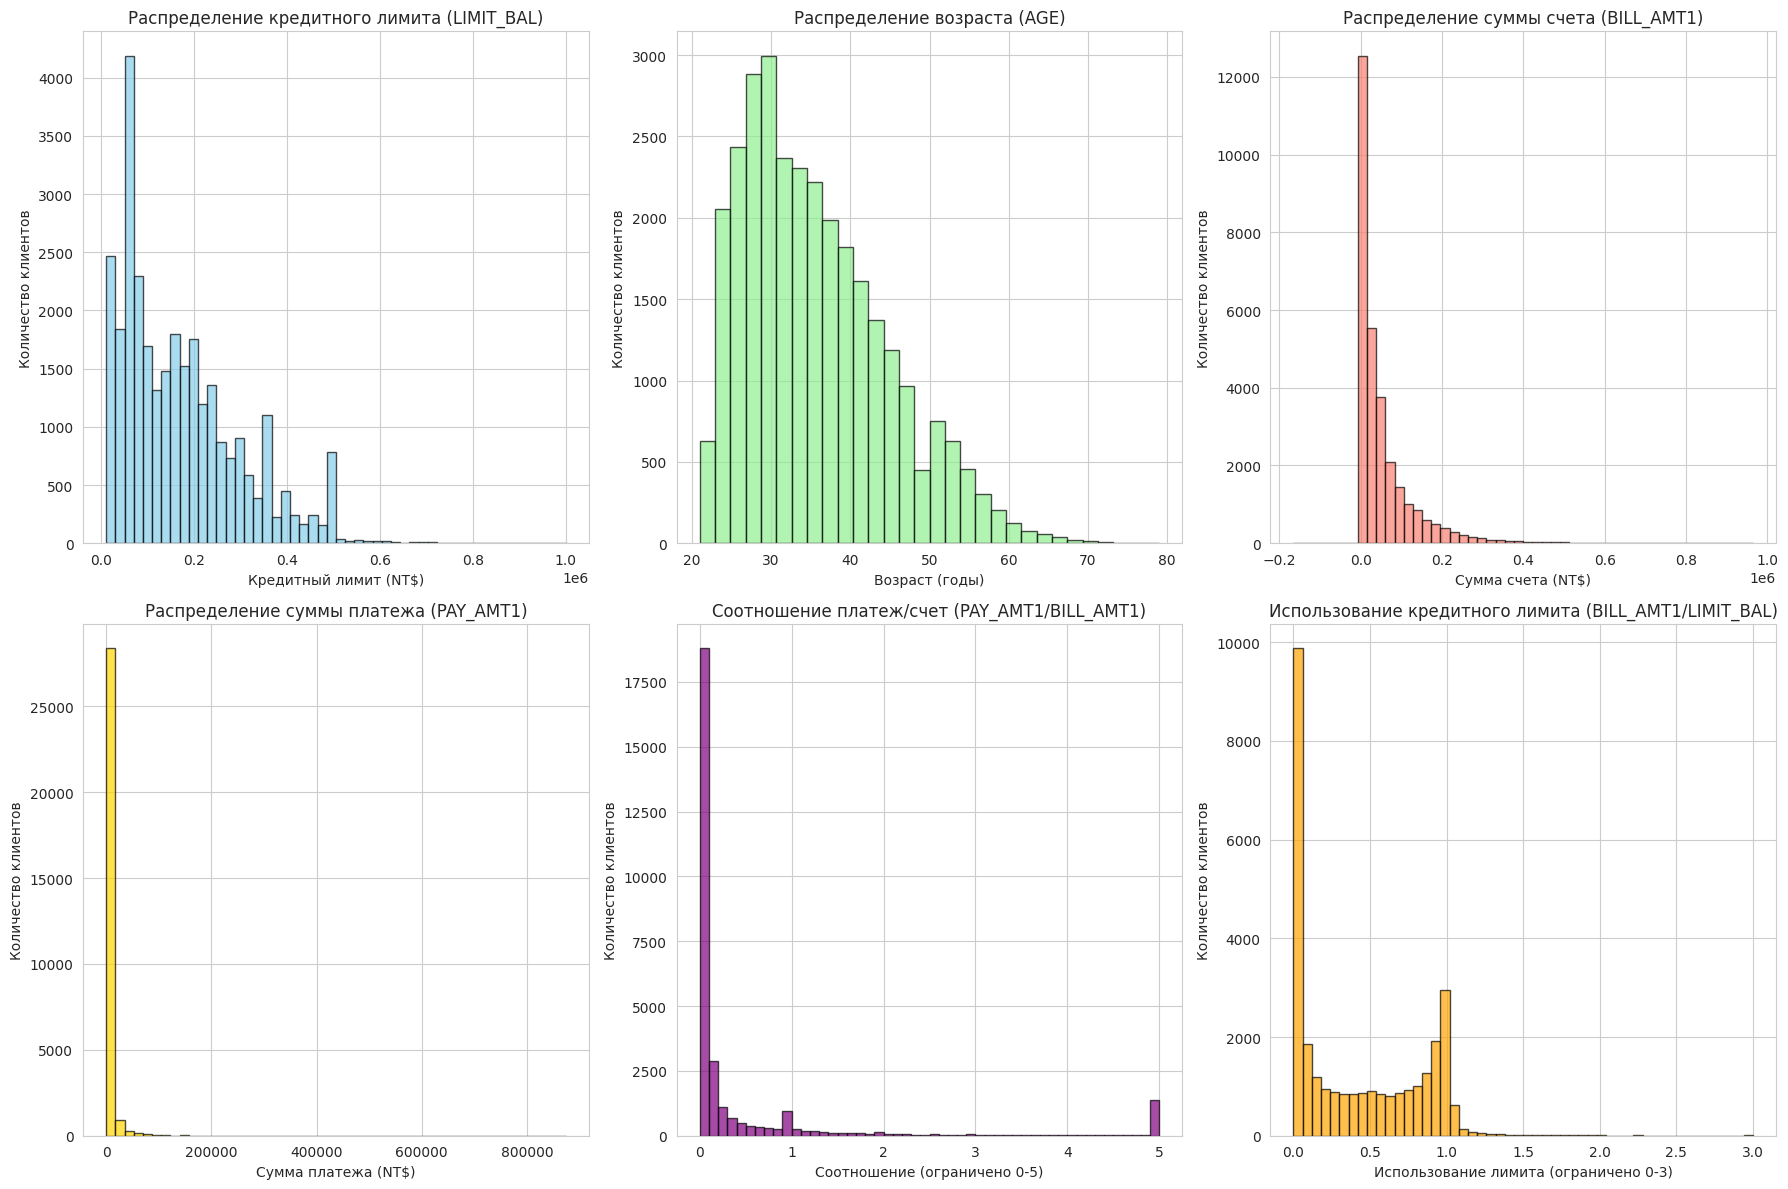

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Кредитный лимит
axes[0,0].hist(df_enhanced['LIMIT_BAL'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Распределение кредитного лимита (LIMIT_BAL)')
axes[0,0].set_xlabel('Кредитный лимит (NT$)')
axes[0,0].set_ylabel('Количество клиентов')

# 2. Возраст
axes[0,1].hist(df_enhanced['AGE'], bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Распределение возраста (AGE)')
axes[0,1].set_xlabel('Возраст (годы)')
axes[0,1].set_ylabel('Количество клиентов')

# 3. Сумма счета (последний месяц)
axes[0,2].hist(df_enhanced['BILL_AMT1'], bins=50, alpha=0.7, color='salmon', edgecolor='black')
axes[0,2].set_title('Распределение суммы счета (BILL_AMT1)')
axes[0,2].set_xlabel('Сумма счета (NT$)')
axes[0,2].set_ylabel('Количество клиентов')

# 4. Сумма платежа (последний месяц)
axes[1,0].hist(df_enhanced['PAY_AMT1'], bins=50, alpha=0.7, color='gold', edgecolor='black')
axes[1,0].set_title('Распределение суммы платежа (PAY_AMT1)')
axes[1,0].set_xlabel('Сумма платежа (NT$)')
axes[1,0].set_ylabel('Количество клиентов')

# 5. Соотношение платежа к сумме счета
df_enhanced['payment_ratio'] = df_enhanced['PAY_AMT1'] / (df_enhanced['BILL_AMT1'] + 1)  # +1 чтобы избежать деления на 0
axes[1,1].hist(df_enhanced['payment_ratio'].clip(0, 5), bins=50, alpha=0.7, color='purple', edgecolor='black')
axes[1,1].set_title('Соотношение платеж/счет (PAY_AMT1/BILL_AMT1)')
axes[1,1].set_xlabel('Соотношение (ограничено 0-5)')
axes[1,1].set_ylabel('Количество клиентов')

# 6. Использование кредитного лимита
df_enhanced['credit_utilization'] = df_enhanced['BILL_AMT1'] / (df_enhanced['LIMIT_BAL'] + 1)
axes[1,2].hist(df_enhanced['credit_utilization'].clip(0, 3), bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1,2].set_title('Использование кредитного лимита (BILL_AMT1/LIMIT_BAL)')
axes[1,2].set_xlabel('Использование лимита (ограничено 0-3)')
axes[1,2].set_ylabel('Количество клиентов')

plt.tight_layout()
plt.show()

Сводные выводы:

1. **Целевая аудитория:** Молодые и среднего возраста клиенты (25–50 лет).
2. **Кредитное поведение:**
   - Большинство клиентов имеют небольшие кредитные лимиты.
   - Многие клиенты не используют кредит или используют его минимально.
   - Значительная часть клиентов не платит в первый месяц.
3. **Риски:**
   - Высокий процент клиентов, которые не платят в первый месяц — это потенциальный риск дефолта.
   - Некоторые клиенты превышают свой кредитный лимит — это также риск.
4. **Возможности:**
   - Можно предложить клиентам с низким использованием кредита более выгодные условия, чтобы стимулировать использование.
   - Для клиентов, которые не платят в первый месяц, можно разработать системы напоминаний или автоматических платежей.

Анализ связи с дефолтом

In [26]:
df_enhanced['LIMIT_BAL_bin'] = pd.cut(df_enhanced['LIMIT_BAL'], bins=5)
df_enhanced['AGE_bin'] = pd.cut(df_enhanced['AGE'], bins=[20, 30, 40, 50, 60, 80])
df_enhanced['credit_utilization_bin'] = pd.cut(df_enhanced['credit_utilization'], bins=[0, 0.2, 0.5, 0.8, 1.0, 3.0])

# Анализ по кредитному лимиту
print("\n КРЕДИТНЫЙ ЛИМИТ (LIMIT_BAL):")
limit_analysis = df_enhanced.groupby('LIMIT_BAL_bin')['default'].agg(['count', 'mean'])
limit_analysis['default_rate'] = (limit_analysis['mean'] * 100).round(1)
for bin_name, row in limit_analysis.iterrows():
    print(f"  {bin_name}: {row['default_rate']}% дефолтов (n={row['count']:,})")

# Анализ по возрасту
print("\n ВОЗРАСТ (AGE):")
age_analysis = df_enhanced.groupby('AGE_bin')['default'].agg(['count', 'mean'])
age_analysis['default_rate'] = (age_analysis['mean'] * 100).round(1)
for bin_name, row in age_analysis.iterrows():
    print(f"  {bin_name}: {row['default_rate']}% дефолтов (n={row['count']:,})")

# Анализ по использованию кредитного лимита
print("\n ИСПОЛЬЗОВАНИЕ КРЕДИТНОГО ЛИМИТА:")
util_analysis = df_enhanced.groupby('credit_utilization_bin')['default'].agg(['count', 'mean'])
util_analysis['default_rate'] = (util_analysis['mean'] * 100).round(1)
for bin_name, row in util_analysis.iterrows():
    print(f"  {bin_name}: {row['default_rate']}% дефолтов (n={row['count']:,})")

СВЯЗЬ КЛЮЧЕВЫХ ПРИЗНАКОВ С ДЕФОЛТОМ:

 КРЕДИТНЫЙ ЛИМИТ (LIMIT_BAL):
  (9010.0, 208000.0]: 25.6% дефолтов (n=20,357.0)
  (208000.0, 406000.0]: 15.3% дефолтов (n=7,805.0)
  (406000.0, 604000.0]: 12.2% дефолтов (n=1,724.0)
  (604000.0, 802000.0]: 7.7% дефолтов (n=78.0)
  (802000.0, 1000000.0]: 0.0% дефолтов (n=1.0)

 ВОЗРАСТ (AGE):
  (20, 30]: 22.5% дефолтов (n=10,997.0)
  (30, 40]: 20.4% дефолтов (n=10,702.0)
  (40, 50]: 23.3% дефолтов (n=5,997.0)
  (50, 60]: 25.2% дефолтов (n=1,997.0)
  (60, 80]: 26.8% дефолтов (n=272.0)

 ИСПОЛЬЗОВАНИЕ КРЕДИТНОГО ЛИМИТА:
  (0.0, 0.2]: 16.7% дефолтов (n=10,652.0)
  (0.2, 0.5]: 21.1% дефолтов (n=4,371.0)
  (0.5, 0.8]: 26.3% дефолтов (n=4,394.0)
  (0.8, 1.0]: 25.5% дефолтов (n=5,866.0)
  (1.0, 3.0]: 30.1% дефолтов (n=2,101.0)


/tmp/ipython-input-3848152729.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  limit_analysis = df_enhanced.groupby('LIMIT_BAL_bin')['default'].agg(['count', 'mean'])
/tmp/ipython-input-3848152729.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_analysis = df_enhanced.groupby('AGE_bin')['default'].agg(['count', 'mean'])
/tmp/ipython-input-3848152729.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  util_an

*Анализ числовых финансовых показателей:*

**Кредитный лимит (LIMIT_BAL) - Обратная зависимость**

```
Низкий лимит (90K-208K): 25.6% дефолтов
Средний лимит (208K-406K): 15.3% дефолтов  
Высокий лимит (406K+): 12.2% дефолтов
Премиум (802K+): 0% дефолтов
```

Вывод: Банк правильно оценивает риски. Надежным клиентам дают высокие лимиты. Риск снижается в 2.1 раза при переходе от низких к высоким лимитам.

**Возраст (AGE) - Рост риска с возрастом**

```
20-30 лет: 22.5% дефолтов
30-40 лет: 20.4% дефолтов
40-50 лет: 23.3% дефолтов
50-60 лет: 25.2% дефолтов
60+ лет: 26.8% дефолтов
```

Вывод: Пожилые клиенты (50+ лет) на 20% рискованнее молодых. Возможные причины: фиксированные доходы, медицинские расходы.

**Использование кредитного лимита - Прямая зависимость**

```
0-20% использования: 16.7% дефолтов
20-50% использования: 21.1% дефолтов  
50-80% использования: 26.3% дефолтов
80-100% использования: 25.5% дефолтов
100%+ использования: 30.1% дефолтов
```

Вывод: Клиенты, исчерпывающие лимит, в 1.8 раза рискованнее. Использование >50% лимита - критический порог.

**Бизнес-рекомендации:**

· Фокус на молодых клиентов с низкими лимитами - наибольший риск дефолта
· Ввести лимиты для высокого использования кредита (>80%) - автоматическое снижение рисков
· Особый контроль за клиентами 50+ лет - повышенная вероятность дефолта
· Премиум-клиенты (высокие лимиты) - наиболее надежная категория

## Корреляционный анализ признаков

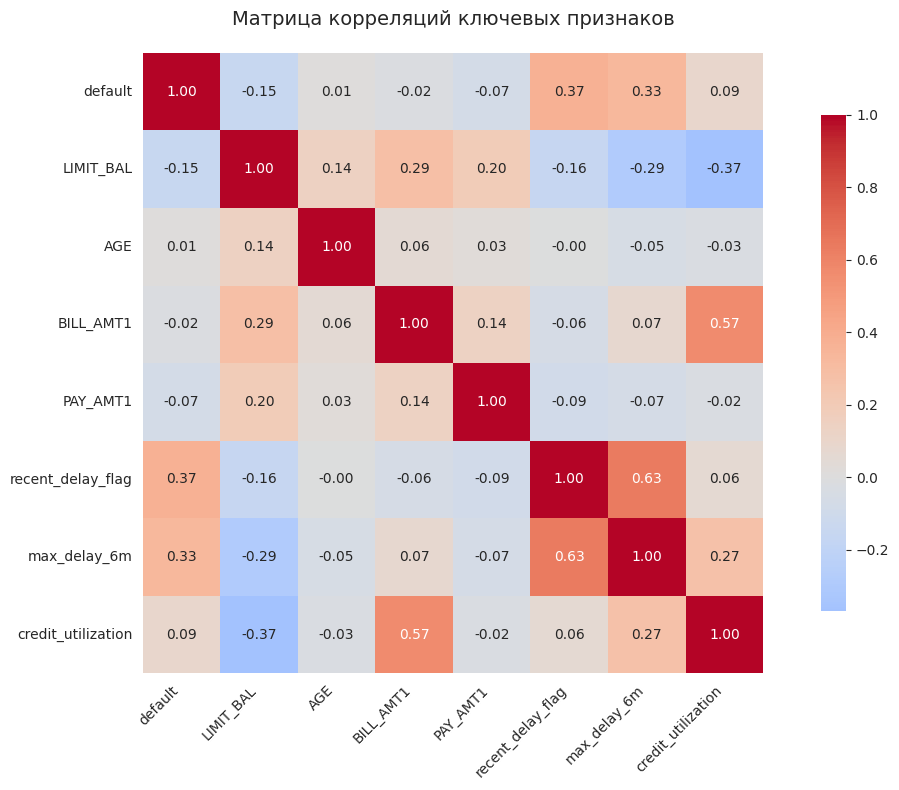

• recent_delay_flag   :  0.369 (сильная положительная корреляция)
• max_delay_6m        :  0.331 (сильная положительная корреляция)
• credit_utilization  :  0.086 (слабая положительная корреляция)
• AGE                 :  0.014 (слабая положительная корреляция)
• BILL_AMT1           : -0.020 (слабая отрицательная корреляция)
• PAY_AMT1            : -0.073 (слабая отрицательная корреляция)
• LIMIT_BAL           : -0.154 (средняя отрицательная корреляция)


In [27]:
key_features = ['default', 'LIMIT_BAL', 'AGE', 'BILL_AMT1', 'PAY_AMT1',
                'recent_delay_flag', 'max_delay_6m', 'credit_utilization']

correlation_matrix = df_enhanced[key_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={'shrink': 0.8})
plt.title('Матрица корреляций ключевых признаков', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

default_correlations = correlation_matrix['default'].sort_values(ascending=False)
for feature, corr in default_correlations.items():
    if feature != 'default':
        strength = "сильная" if abs(corr) > 0.3 else "средняя" if abs(corr) > 0.1 else "слабая"
        direction = "положительная" if corr > 0 else "отрицательная"
        print(f"• {feature:20}: {corr:6.3f} ({strength} {direction} корреляция)")

**Выводы**:

1. **Главные предикторы дефолта (`default`):**
   - `recent_delay_flag` (0.37)
   - `max_delay_6m` (0.33)
   - `credit_utilization` (0.09) — слабая связь
   - `LIMIT_BAL` (-0.15) — отрицательная связь

   Самые важные факторы — **история задержек платежей**. Использование лимита и размер лимита играют второстепенную роль.

2. **Сильные взаимосвязи между переменными:**
   - `recent_delay_flag` <-> `max_delay_6m` (0.63) — очень сильная связь.
   - `BILL_AMT1` <->`credit_utilization` (0.57) — логичное следствие формулы.
   - `LIMIT_BAL` <-> `credit_utilization` (-0.37) — также логично.

3. **Возраст (`AGE`) не является значимым фактором** — его корреляция со всеми переменными слабая.

## Подготовка данных для машинного обучения

In [29]:
# Объединяем редкие категории в EDUCATION
df_enhanced['EDUCATION'] = df_enhanced['EDUCATION'].replace({0: 4, 5: 4, 6: 4})
print(" EDUCATION: категории 0,5,6 объединены в '4' (Другое)")

# Объединяем редкие категории в MARRIAGE
df_enhanced['MARRIAGE'] = df_enhanced['MARRIAGE'].replace({0: 3})
print(" MARRIAGE: категория 0 объединена с '3' (Другое)")

# One-Hot Encoding для категориальных признаков
categorical_cols = ['SEX', 'EDUCATION', 'MARRIAGE']
df_encoded = pd.get_dummies(df_enhanced, columns=categorical_cols, prefix=categorical_cols)
print(" Категориальные признаки закодированы One-Hot Encoding")

# Исключаем исходные PAY_ признаки (используем производные)
exclude_features = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
                   'payment_ratio', 'credit_utilization', 'LIMIT_BAL_bin',
                   'AGE_bin', 'credit_utilization_bin']


feature_columns = [col for col in df_encoded.columns
                  if col not in exclude_features and col != 'default']

print(f"✓ Отобрано {len(feature_columns)} признаков для модели:")
for i, feature in enumerate(feature_columns[:10], 1):  # Первые 10
    print(f"   {i:2}. {feature}")
if len(feature_columns) > 10:
    print(f"   ... и еще {len(feature_columns) - 10} признаков")

 EDUCATION: категории 0,5,6 объединены в '4' (Другое)
 MARRIAGE: категория 0 объединена с '3' (Другое)
 Категориальные признаки закодированы One-Hot Encoding
✓ Отобрано 29 признаков для модели:
    1. LIMIT_BAL
    2. AGE
    3. BILL_AMT1
    4. BILL_AMT2
    5. BILL_AMT3
    6. BILL_AMT4
    7. BILL_AMT5
    8. BILL_AMT6
    9. PAY_AMT1
   10. PAY_AMT2
   ... и еще 19 признаков


In [30]:
X = df_encoded[feature_columns]
y = df_encoded['default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f" Обучающая выборка: {X_train.shape[0]:,} записей")
print(f" Тестовая выборка: {X_test.shape[0]:,} записей")
print(f" Количество признаков: {X_train.shape[1]}")
print(f" Распределение дефолтов в train: {y_train.mean():.1%}")
print(f" Распределение дефолтов в test: {y_test.mean():.1%}")

 Обучающая выборка: 23,972 записей
 Тестовая выборка: 5,993 записей
 Количество признаков: 29
 Распределение дефолтов в train: 22.1%
 Распределение дефолтов в test: 22.1%


In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" Данные масштабированы (StandardScaler)")
print(f" Размерность данных: {X_train_scaled.shape}")

 Данные масштабированы (StandardScaler)
 Размерность данных: (23972, 29)


## Построение моделей машинного обучения

In [34]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"Обучение {name}...")

    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    accuracy = model.score(X_test_scaled, y_test)
    auc = roc_auc_score(y_test, y_pred_proba)

    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc')

    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'auc': auc,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }

    print(f"  Accuracy: {accuracy:.3f}, AUC: {auc:.3f}, CV AUC: {cv_scores.mean():.3f}")

print("\nСРАВНЕНИЕ МОДЕЛЕЙ:")
print("=" * 30)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[name]['accuracy'] for name in results],
    'AUC': [results[name]['auc'] for name in results],
    'CV AUC Mean': [results[name]['cv_mean'] for name in results],
    'CV AUC Std': [results[name]['cv_std'] for name in results]
}).sort_values('AUC', ascending=False)

print(comparison_df.to_string(index=False))

best_model_name = comparison_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\n ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")

Обучение Logistic Regression...
  Accuracy: 0.807, AUC: 0.753, CV AUC: 0.761
Обучение Random Forest...
  Accuracy: 0.810, AUC: 0.757, CV AUC: 0.759
Обучение Gradient Boosting...
  Accuracy: 0.812, AUC: 0.769, CV AUC: 0.780
Обучение SVM...
  Accuracy: 0.808, AUC: 0.715, CV AUC: 0.733

СРАВНЕНИЕ МОДЕЛЕЙ:
              Model  Accuracy      AUC  CV AUC Mean  CV AUC Std
  Gradient Boosting  0.811614 0.769272     0.780435    0.004912
      Random Forest  0.810279 0.756534     0.759104    0.008028
Logistic Regression  0.806775 0.752618     0.760569    0.007249
                SVM  0.807943 0.714924     0.732863    0.009225

 ЛУЧШАЯ МОДЕЛЬ: Gradient Boosting


**Лучшая модель (Gradient Boosting)**:
- **Достаточно хороша** для **стартового решения**, MVP или внутреннего аналитического инструмента.
- **Может быть использована в продакшене**, если:
  - Дополнить её **правилами бизнес-логики** (например, hard cutoff по возрасту/доходу)
  - Использовать как часть скоринговой карты
  - Есть **возможность дообучения** на новых данных.
- **Недостаточна** для **автоматического принятия решений по крупным кредитам** без дополнительной доработки.


## Создание Gradio интерфейса

In [51]:
# Сохраняем лучшую модель (Gradient Boosting)
joblib.dump(best_model, 'gradient_boosting_model.pkl')

# Сохраняем scaler
joblib.dump(scaler, 'scaler.pkl')

# Сохраняем информацию о признаках
feature_info = {
    'feature_columns': feature_columns,
    'categorical_mappings': {
        'SEX': {1: 'Мужской', 2: 'Женский'},
        'EDUCATION': {1: 'Аспирант', 2: 'Университет', 3: 'Школа', 4: 'Другое'},
        'MARRIAGE': {1: 'Женат/Замужем', 2: 'Холост/Не замужем', 3: 'Другое'}
    }
}

with open('feature_info.json', 'w') as f:
    json.dump(feature_info, f)
print("Информация о признаках сохранена")

# Загружаем файлы обратно для проверки
print("\n2. ЗАГРУЗКА ФАЙЛОВ ДЛЯ ИНТЕРФЕЙСА")
print("-" * 40)

model = joblib.load('gradient_boosting_model.pkl')
scaler = joblib.load('scaler.pkl')

with open('feature_info.json', 'r') as f:
    feature_info = json.load(f)

feature_columns = feature_info['feature_columns']
print("Все файлы успешно загружены")

# Функция для предсказания
def predict_credit_risk(limit_bal, age, sex, education, marriage,
                       bill_amt1, pay_amt1, recent_delay_flag,
                       max_delay_6m, total_delays_count):

    # Преобразуем категориальные переменные в числовые
    sex_numeric = 1 if sex == "Мужской" else 2

    education_mapping = {
        "Аспирант": 1, "Университет": 2, "Школа": 3, "Другое": 4
    }
    education_numeric = education_mapping[education]

    marriage_mapping = {
        "Женат/Замужем": 1, "Холост/Не замужем": 2, "Другое": 3
    }
    marriage_numeric = marriage_mapping[marriage]

    recent_delay_numeric = 1 if recent_delay_flag == "Да" else 0

    # Создаем словарь с введенными данными
    input_data = {
        'LIMIT_BAL': limit_bal,
        'AGE': age,
        'BILL_AMT1': bill_amt1,
        'PAY_AMT1': pay_amt1,
        'recent_delay_flag': recent_delay_numeric,
        'max_delay_6m': max_delay_6m,
        'total_delays_count': total_delays_count,
        'SEX_1': 1 if sex_numeric == 1 else 0,
        'SEX_2': 1 if sex_numeric == 2 else 0,
        'EDUCATION_1': 1 if education_numeric == 1 else 0,
        'EDUCATION_2': 1 if education_numeric == 2 else 0,
        'EDUCATION_3': 1 if education_numeric == 3 else 0,
        'EDUCATION_4': 1 if education_numeric == 4 else 0,
        'MARRIAGE_1': 1 if marriage_numeric == 1 else 0,
        'MARRIAGE_2': 1 if marriage_numeric == 2 else 0,
        'MARRIAGE_3': 1 if marriage_numeric == 3 else 0
    }

    input_df = pd.DataFrame([input_data])

    for col in feature_columns:
        if col not in input_df.columns:
            input_df[col] = 0

    input_df = input_df[feature_columns]

    input_scaled = scaler.transform(input_df)

    probability = model.predict_proba(input_scaled)[0, 1]

    if probability < 0.3:
        result = "✅ НИЗКИЙ РИСК ДЕФОЛТА"
        recommendation = "Рекомендация: ОДОБРИТЬ кредит"
        color = "green"
    elif probability < 0.6:
        result = "⚠️ СРЕДНИЙ РИСК ДЕФОЛТА"
        recommendation = "Рекомендация: ДОПОЛНИТЕЛЬНАЯ ПРОВЕРКА"
        color = "orange"
    else:
        result = "🚨 ВЫСОКИЙ РИСК ДЕФОЛТА"
        recommendation = "Рекомендация: ОТКЛОНИТЬ заявку"
        color = "red"

    # Описание для максимальной задержки
    delay_descriptions = {
        -2: "Нет операций",
        -1: "Всегда вовремя",
        0: "Использовал рассрочку",
        1: "Задержка 1 месяц",
        2: "Задержка 2 месяца",
        3: "Задержка 3 месяца",
        4: "Задержка 4 месяца",
        5: "Задержка 5 месяцев",
        6: "Задержка 6 месяцев",
        7: "Задержка 7 месяцев",
        8: "Задержка 8 месяцев"
    }

    delay_desc = delay_descriptions.get(max_delay_6m, f"Задержка {max_delay_6m} месяцев")

    output = f"""
{result}

📊 ВЕРОЯТНОСТЬ ДЕФОЛТА: {probability:.1%}
💳 ВЕРОЯТНОСТЬ ВЫПЛАТЫ: {(1-probability):.1%}

{recommendation}

---
📋 ДЕТАЛИ КЛИЕНТА:
• Кредитный лимит: {limit_bal:,} NT$
• Возраст: {age} лет
• Пол: {sex}
• Образование: {education}
• Семейное положение: {marriage}

💳 ФИНАНСОВЫЕ ПОКАЗАТЕЛИ:
• Сумма счета: {bill_amt1:,} NT$
• Сумма платежа: {pay_amt1:,} NT$

📅 ИСТОРИЯ ПЛАТЕЖЕЙ:
• Задержка в последнем месяце: {recent_delay_flag}
• Максимальная задержка: {delay_desc}
• Месяцев с задержками: {total_delays_count} из 6
"""

    return output

# Создаем интерфейс
print("\n3. СОЗДАНИЕ GRADIO ИНТЕРФЕЙСА")
print("-" * 35)

inputs = [
    gr.Number(label="Кредитный лимит (NT$)", value=150000, minimum=10000, maximum=1000000,
             info="Минимум: 10,000 NT$, Максимум: 1,000,000 NT$"),

    gr.Number(label="Возраст", value=35, minimum=21, maximum=79,
             info="Возраст клиента в годах"),

    gr.Radio(label="Пол", choices=["Мужской", "Женский"], value="Женский"),

    gr.Radio(label="Образование",
             choices=["Аспирант", "Университет", "Школа", "Другое"],
             value="Университет",
             info="Уровень образования клиента"),

    gr.Radio(label="Семейное положение",
             choices=["Женат/Замужем", "Холост/Не замужем", "Другое"],
             value="Холост/Не замужем"),

    gr.Number(label="Сумма счета (последний месяц, NT$)",
             value=50000, minimum=-200000, maximum=1000000,
             info="Сумма выставленного счета за последний месяц"),

    gr.Number(label="Сумма платежа (последний месяц, NT$)",
             value=5000, minimum=0, maximum=1000000,
             info="Сумма, которую клиент фактически заплатил"),

    gr.Radio(label="Задержка платежа в последнем месяце",
             choices=["Нет", "Да"], value="Нет",
             info="Была ли задержка платежа в последнем месяце"),

    gr.Slider(label="Максимальная задержка за 6 месяцев",
              minimum=-2, maximum=8, value=0, step=1,
              info="-2: Нет операций, -1: Оплачено вовремя, 0: Использована рассрочка, 1+: Задержка в месяцах"),

    gr.Slider(label="Количество месяцев с задержками",
              minimum=0, maximum=6, value=0, step=1,
              info="Сколько месяцев из последних 6 были с задержками платежей")
]

print("Запускаем интерфейс...")

interface = gr.Interface(
    fn=predict_credit_risk,
    inputs=inputs,
    outputs=gr.Textbox(label="Результат оценки кредитного риска", lines=15),
    title="🏦 СИСТЕМА ОЦЕНКИ КРЕДИТНОГО РИСКА",
    description="""Оцените вероятность дефолта клиента по кредитной карте на основе машинного обучения.

    🎯 **Метрики модели:** Accuracy: 81.2%, AUC: 76.9%
    📊 **Обучена на:** 30,000 клиентов банка
    ⚡ **Основные факторы риска:** история платежей, использование кредитного лимита
    """,
    examples=[
        [150000, 35, "Женский", "Университет", "Холост/Не замужем", 50000, 5000, "Нет", 0, 0],
        [80000, 45, "Мужской", "Школа", "Женат/Замужем", 75000, 2000, "Да", 2, 3],
        [300000, 28, "Женский", "Аспирант", "Холост/Не замужем", 100000, 8000, "Нет", -1, 0],
        [50000, 55, "Мужской", "Другое", "Другое", 45000, 1000, "Да", 3, 4]
    ],
    theme="soft"
)

interface.launch(share=True, debug=True)

Информация о признаках сохранена

2. ЗАГРУЗКА ФАЙЛОВ ДЛЯ ИНТЕРФЕЙСА
----------------------------------------
Все файлы успешно загружены

3. СОЗДАНИЕ GRADIO ИНТЕРФЕЙСА
-----------------------------------
Запускаем интерфейс...
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://6cda4cc64787f2efc3.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/gradio/queueing.py", line 759, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/route_utils.py", line 354, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 2112, in process_api
    inputs = await self.preprocess_data(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/blocks.py", line 1774, in preprocess_data
    processed_input.append(block.preprocess(inputs_cached))
                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/gradio/components/number.py", line 142, in preprocess
    self.raise_if_out_of_bounds(payload, self.minimum, self.maximum)
  Fi

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://6cda4cc64787f2efc3.gradio.live
